## Test the model on the unseen data

## Import library

In [1]:
from __future__ import print_function
import torch, os, copy, time, pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob, pickle
import seaborn as sn
start_time= time.time()
import zipfile as zf

## Upload test images and define variables

In [2]:
## Sensitivity: the ability of a test to correctly identify patients with a disease.
## Specificity: the ability of a test to correctly identify people without the disease. 
## True positive: the person has the disease and the test is positive. 
## True negative: the person does not have the disease and the test is negative.

cut_off_threshold=0.2 # default value
batch_size=20
num_workers=0
trained_model_path='./covid_resnet18_epoch30.pt'


In [4]:

############### Utility function to find sensitivity and specificity for different cut-off thresholds
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob >= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (noncovid_prob < thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class_names = ['covid','non']

############### Test on trained model
model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()




############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()  # Applies the Softmax function to an n-dimensional input Tensor rescaling them so that 
# the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.



############### Get the predicted probabilities of all samples
test_covid  = glob.glob(r'D:\HOMA\sharpest_mind\test_sample\covid\*') 
test_non    = glob.glob(r'D:\HOMA\sharpest_mind\test_sample\non\*')

covid_pred= np.zeros([len(test_covid),1]).astype(int)
non_pred  = np.zeros([len(test_non),1]).astype(int)

covid_prob= np.zeros([len(test_covid),1])
non_prob   = np.zeros([len(test_non),1])


for i in range(len(test_covid)):
    cur_img= image_loader(test_covid[i])
    model_output= model(cur_img)
    cur_pred = model_output.max(1, keepdim=True)[1]# Returns the maximum value of all elements in the input tensor 
                                                     #If keepdim is True, the output tensors are of the same size as input
    cur_prob = sm(model_output)
    covid_prob[i,:]= cur_prob.data.numpy()[0,0]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred.data.numpy())]) )


for i in range(len(test_non)):
    cur_img= image_loader(test_non[i])
    model_output= model(cur_img)
    cur_pred = model_output.max(1, keepdim=True)[1]  # Returns the maximum value of all elements in the input tensor 
                                                     #If keepdim is True, the output tensors are of the same size as input
    cur_prob = sm(model_output)
    non_prob[i,:]= cur_prob.data.numpy()[0,0]
    print("%03d Non-Covid predicted label:%s" %(i, class_names[int(cur_pred.data.numpy())]) )



#pickle.dump( covid_prob, open( "./results/covid_prob_%s.p" %model_name, "wb" ) )
#pickle.dump( non_prob, open(   "./results/non_prob_%s.p" %model_name, "wb" ) )



############### find sensitivity and specificity
thresh= cut_off_threshold
sensitivity_40, specificity= find_sens_spec( covid_prob, non_prob, thresh)



############### derive labels based on probabilities and cut-off threshold
covid_pred = np.where( covid_prob  >thresh, 1, 0)
non_pred   = np.where( non_prob  >thresh,   1, 0)



############### derive confusion-matrix
covid_list= [int(covid_pred[i]) for i in range(len(covid_pred))]
covid_count = [(x, covid_list.count(x)) for x in set(covid_list)]

non_list= [int(non_pred[i]) for i in range(len(non_pred))]
non_count = [(x, non_list.count(x)) for x in set(non_list)]

y_pred_list= covid_list+non_list
y_test_list= [1 for i in range(len(covid_list))]+[0 for i in range(len(non_list))]

y_pred= np.asarray(y_pred_list, dtype=np.int64)
y_test= np.asarray(y_test_list, dtype=np.int64)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)   



C:\Users\Home\AppData\Local\Temp\ipykernel_16548\200798931.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = sm(model_output)


000 Covid predicted label:non
001 Covid predicted label:non
002 Covid predicted label:non
003 Covid predicted label:non
004 Covid predicted label:non
005 Covid predicted label:non
006 Covid predicted label:non
007 Covid predicted label:non
008 Covid predicted label:non
009 Covid predicted label:non
010 Covid predicted label:non
011 Covid predicted label:non
012 Covid predicted label:non
013 Covid predicted label:non
014 Covid predicted label:non
015 Covid predicted label:non
016 Covid predicted label:non
017 Covid predicted label:non
018 Covid predicted label:non
019 Covid predicted label:non
020 Covid predicted label:non
021 Covid predicted label:non
022 Covid predicted label:non
023 Covid predicted label:non
024 Covid predicted label:non
025 Covid predicted label:non
026 Covid predicted label:non
027 Covid predicted label:non
028 Covid predicted label:non
029 Covid predicted label:non
030 Covid predicted label:non
031 Covid predicted label:non
032 Covid predicted label:non
033 Covid 

C:\Users\Home\AppData\Local\Temp\ipykernel_16548\200798931.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = sm(model_output)


000 Non-Covid predicted label:non
001 Non-Covid predicted label:non
002 Non-Covid predicted label:non
003 Non-Covid predicted label:non
004 Non-Covid predicted label:non
005 Non-Covid predicted label:non
006 Non-Covid predicted label:non
007 Non-Covid predicted label:non
008 Non-Covid predicted label:non
009 Non-Covid predicted label:non
010 Non-Covid predicted label:non
011 Non-Covid predicted label:non
012 Non-Covid predicted label:non
013 Non-Covid predicted label:non
014 Non-Covid predicted label:non
015 Non-Covid predicted label:non
016 Non-Covid predicted label:non
017 Non-Covid predicted label:non
018 Non-Covid predicted label:non
019 Non-Covid predicted label:non
020 Non-Covid predicted label:non
021 Non-Covid predicted label:non
022 Non-Covid predicted label:non
023 Non-Covid predicted label:non
024 Non-Covid predicted label:non
025 Non-Covid predicted label:non
026 Non-Covid predicted label:non
027 Non-Covid predicted label:non
028 Non-Covid predicted label:non
029 Non-Covid 

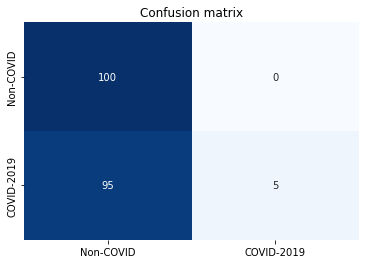


Total Time: 495799.0655698776


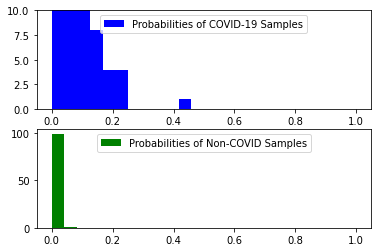

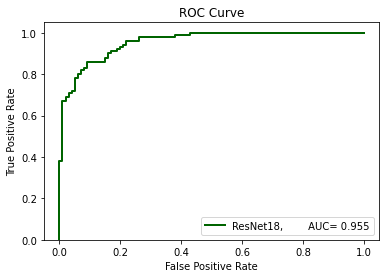

In [5]:
# Plot normalized confusion matrix
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                 columns = [i for i in class_names])


ax = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019'])
ax.set_title("Confusion matrix")
plt.savefig('./confusion_matrix.png')#dpi = 200
plt.show()





############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob, bins, color= 'green', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('./scores_histogram.png') #dpi = 200

############### ROC Curve and AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



y_test_res18= [1 for i in range(len(covid_prob))]+[0 for i in range(len(non_prob))]
y_pred_res18= [covid_prob[i] for i in range(len(covid_prob))]+[non_prob[i] for i in range(len(non_prob))]

           
auc_res18 = roc_auc_score(y_test_res18, y_pred_res18)
ns_fpr_res18, ns_tpr_res18, _ = roc_curve(y_test_res18, y_pred_res18)

plt.figure()
pyplot.plot(ns_fpr_res18, ns_tpr_res18,  color='darkgreen', linewidth=2,   label='ResNet18,        AUC= %.3f' %auc_res18)
pyplot.ylim([0,1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve")
# show the legend
pyplot.legend(loc='lower right')
plt.savefig('./ROC_covid19.png') #dpi = 200



end_time= time.time()
tot_time= end_time- start_time
print("\nTotal Time:", tot_time)